In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm

from typing import Set, List
from datetime import datetime as dt
from functools import partial, wraps

from plasticc.featurize import process_meta, featurize
from plasticc.training import path_from_cv_score, train_and_validate, random_search
from plasticc.final import featurize_test, predict_test

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
fcp = {
    'flux': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
    },

    'flux_by_flux_ratio_sq': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,       
    },

    'flux_passband': {
        'fft_coefficient': [
                {'coeff': 0, 'attr': 'abs'}, 
                {'coeff': 1, 'attr': 'abs'}
            ],
        'kurtosis' : None,
        'skewness' : None,
        # new:
#         'sample_entropy': None,
#         'mean_second_derivative_central': None,
#         'mean_abs_change': None,
#         'index_mass_quantile': [
#             {'q': 0.5}
#         ],
#         'fft_aggregated': [
#             {'aggtype': 'centroid'},
#             {'aggtype': 'variance'},
#             {'aggtype': 'skew'},
#             {'aggtype': 'kurtosis'},
#         ]
    },

    'mjd': {
        'maximum': None, 
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
    },
}

In [11]:
aggs = {
    'mjd': ['count', 'mean']  # new
    'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum', 'skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

### Generate features for model training

In [12]:
%%time
meta_train = process_meta('../data/raw/training_set_metadata.csv')
train = pd.read_csv('../data/raw/training_set.csv')

CPU times: user 1.31 s, sys: 216 ms, total: 1.52 s
Wall time: 972 ms


In [13]:
%%time
X = featurize(train, meta_train, aggs, fcp, n_jobs=4)

Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 15.15it/s]


CPU times: user 1min, sys: 1.9 s, total: 1min 2s
Wall time: 28.6 s


In [14]:
if 'target' in X:
    y = X['target']
    del X['target']
else:
    print("What the duck")
    3//0

In [15]:
%%time
train_mean = X.mean(axis=0)
#train_mean.to_hdf('train_data.hdf5', 'data')
# pd.set_option('display.max_rows', 500)
#import pdb; pdb.set_trace()
X.fillna(0, inplace=True)

CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 7.49 ms


In [16]:
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)  # TODO: Move to featurize

In [17]:
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X=X.values)

In [18]:
X.shape

(7848, 69)

In [19]:
y.shape

(7848,)

### Train model with CV

In [20]:
colnames_to_ignore = set([
    'object_id',
    'hostgal_specz',
    'ra',
    'decl',
    'gal_l',
    'gal_b',
    'ddf',
    
])
colnames_to_ignore_restrictive = colnames_to_ignore | set([
    'latlon1',
    'haversine',
])
colnames_to_ignore_very_restrictive = colnames_to_ignore_restrictive | set([
    'flux_err_skew',
    'flux_by_flux_ratio_sq_sum'
])
id_colname = 'object_id'

In [21]:
feature_colnames = [col for col in X.columns if col not in colnames_to_ignore_very_restrictive]

In [44]:
model_params = {
    'num_hidden_layers': 5, 
    'hidden_layer_dim': 96, 
    'dropout_pct': 0.5,
    'optimizer_lr': 0.5,
}
fit_params = {
    'batch_size': 24,
    'epochs': 128,
    'verbose': True
}

Train on 6274 samples, validate on 1574 samples
Epoch 1/128
6274/6274 [==============================] - 3s 457us/step - loss: 24.1804 - categorical_accuracy: 0.1425 - multi_weighted_logloss: 1.6687 - val_loss: 1.0631 - val_categorical_accuracy: 0.4384 - val_multi_weighted_logloss: 1.0631
Epoch 2/128
6274/6274 [==============================] - 1s 148us/step - loss: 21.1700 - categorical_accuracy: 0.2407 - multi_weighted_logloss: 1.4546 - val_loss: 0.9658 - val_categorical_accuracy: 0.3926 - val_multi_weighted_logloss: 0.9658
Epoch 3/128
6274/6274 [==============================] - 1s 153us/step - loss: 19.0087 - categorical_accuracy: 0.3030 - multi_weighted_logloss: 1.3000 - val_loss: 0.9152 - val_categorical_accuracy: 0.4206 - val_multi_weighted_logloss: 0.9152
Epoch 4/128
6274/6274 [==============================] - 1s 130us/step - loss: 17.9759 - categorical_accuracy: 0.3247 - multi_weighted_logloss: 1.2404 - val_loss: 0.8619 - val_categorical_accuracy: 0.4733 - val_multi_weighted_

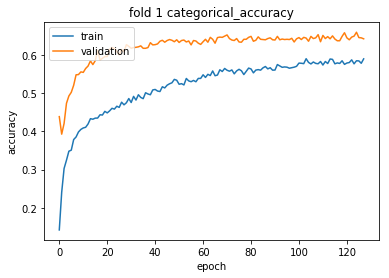

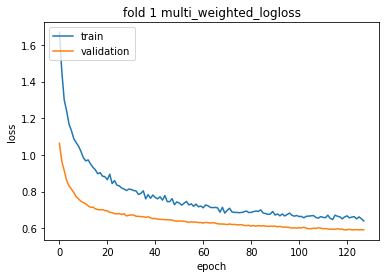

no 1-fold loss: 1.0000384744389377
Train on 6276 samples, validate on 1572 samples
Epoch 1/128
6276/6276 [==============================] - 3s 495us/step - loss: 24.7056 - categorical_accuracy: 0.1061 - multi_weighted_logloss: 1.7058 - val_loss: 1.1437 - val_categorical_accuracy: 0.4039 - val_multi_weighted_logloss: 1.1437
Epoch 2/128
6276/6276 [==============================] - 1s 149us/step - loss: 21.2091 - categorical_accuracy: 0.2043 - multi_weighted_logloss: 1.4723 - val_loss: 0.9625 - val_categorical_accuracy: 0.3887 - val_multi_weighted_logloss: 0.9625
Epoch 3/128
6276/6276 [==============================] - 1s 137us/step - loss: 19.0382 - categorical_accuracy: 0.2884 - multi_weighted_logloss: 1.3212 - val_loss: 0.8920 - val_categorical_accuracy: 0.4173 - val_multi_weighted_logloss: 0.8920
Epoch 4/128
6276/6276 [==============================] - 1s 134us/step - loss: 17.6454 - categorical_accuracy: 0.3287 - multi_weighted_logloss: 1.2067 - val_loss: 0.8489 - val_categorical_acc

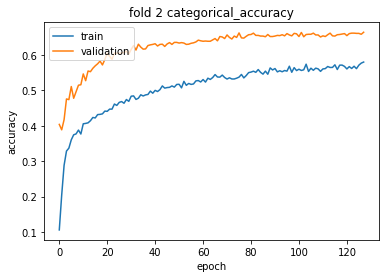

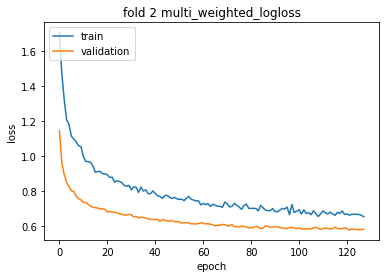

no 2-fold loss: 0.9405656732588057
Train on 6277 samples, validate on 1571 samples
Epoch 1/128
6277/6277 [==============================] - 3s 516us/step - loss: 24.7059 - categorical_accuracy: 0.1209 - multi_weighted_logloss: 1.7002 - val_loss: 1.1486 - val_categorical_accuracy: 0.3577 - val_multi_weighted_logloss: 1.1486
Epoch 2/128
6277/6277 [==============================] - 1s 153us/step - loss: 20.8122 - categorical_accuracy: 0.2353 - multi_weighted_logloss: 1.4359 - val_loss: 1.0058 - val_categorical_accuracy: 0.3927 - val_multi_weighted_logloss: 1.0058
Epoch 3/128
6277/6277 [==============================] - 1s 159us/step - loss: 19.2091 - categorical_accuracy: 0.2906 - multi_weighted_logloss: 1.3243 - val_loss: 0.9471 - val_categorical_accuracy: 0.3908 - val_multi_weighted_logloss: 0.9471
Epoch 4/128
6277/6277 [==============================] - 1s 148us/step - loss: 18.2819 - categorical_accuracy: 0.3320 - multi_weighted_logloss: 1.2527 - val_loss: 0.9169 - val_categorical_acc

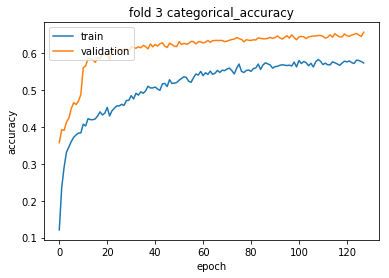

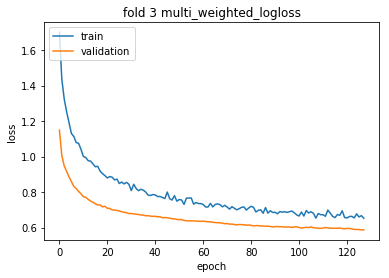

no 3-fold loss: 0.9166355236159127
Train on 6281 samples, validate on 1567 samples
Epoch 1/128
6281/6281 [==============================] - 4s 558us/step - loss: 25.2270 - categorical_accuracy: 0.1103 - multi_weighted_logloss: 1.7500 - val_loss: 1.1765 - val_categorical_accuracy: 0.3874 - val_multi_weighted_logloss: 1.1765
Epoch 2/128
6281/6281 [==============================] - 1s 152us/step - loss: 21.6645 - categorical_accuracy: 0.2057 - multi_weighted_logloss: 1.4932 - val_loss: 0.9974 - val_categorical_accuracy: 0.4518 - val_multi_weighted_logloss: 0.9974
Epoch 3/128
6281/6281 [==============================] - 1s 137us/step - loss: 20.1388 - categorical_accuracy: 0.2681 - multi_weighted_logloss: 1.3881 - val_loss: 0.9244 - val_categorical_accuracy: 0.4352 - val_multi_weighted_logloss: 0.9244
Epoch 4/128
6281/6281 [==============================] - 1s 143us/step - loss: 18.1495 - categorical_accuracy: 0.3100 - multi_weighted_logloss: 1.2565 - val_loss: 0.8744 - val_categorical_acc

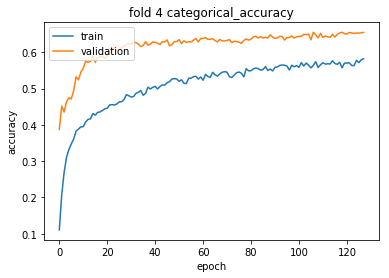

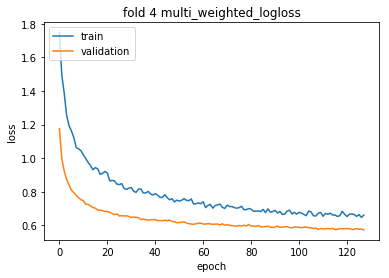

no 4-fold loss: 0.956921027566355
Train on 6284 samples, validate on 1564 samples
Epoch 1/128
6284/6284 [==============================] - 4s 559us/step - loss: 25.1330 - categorical_accuracy: 0.1249 - multi_weighted_logloss: 1.7381 - val_loss: 1.1289 - val_categorical_accuracy: 0.4207 - val_multi_weighted_logloss: 1.1289
Epoch 2/128
6284/6284 [==============================] - 1s 153us/step - loss: 21.2786 - categorical_accuracy: 0.2260 - multi_weighted_logloss: 1.4787 - val_loss: 0.9784 - val_categorical_accuracy: 0.4367 - val_multi_weighted_logloss: 0.9784
Epoch 3/128
6284/6284 [==============================] - 1s 153us/step - loss: 19.2977 - categorical_accuracy: 0.2858 - multi_weighted_logloss: 1.3229 - val_loss: 0.9175 - val_categorical_accuracy: 0.4335 - val_multi_weighted_logloss: 0.9175
Epoch 4/128
6284/6284 [==============================] - 1s 142us/step - loss: 18.0444 - categorical_accuracy: 0.3253 - multi_weighted_logloss: 1.2383 - val_loss: 0.8799 - val_categorical_accu

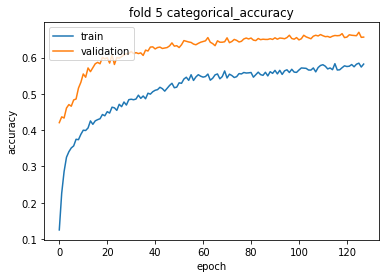

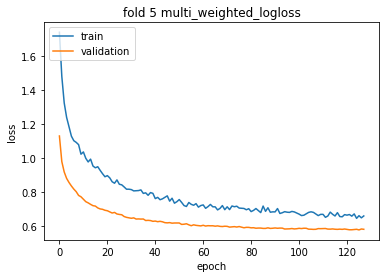

no 5-fold loss: 0.9635036414332757
MULTI WEIGHTED LOG LOSS: 0.95576


In [45]:
clfs, score, _ = train_and_validate(
    X=X, 
    y=y, 
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    model='mlp',
    model_params=model_params,
    fit_params=fit_params,
    nr_fold=3,
)

### Generate sample predictions to see whether CV score is more representative here than in LGBM

In [46]:
def keras_predict_chunk(X, clfs, classes, features, verbose=False):
    # Make predictions
    preds_ = None
    if verbose:
        for clf in tqdm(clfs):  # display progressbar
            if preds_ is None:
                preds_ = clf.predict(X[features].values.astype(np.float32))
            else:
                preds_ += clf.predict(X[features].values.astype(np.float32))
    else:
        for clf in clfs:
            if preds_ is None:
                preds_ = clf.predict(X[features].values.astype(np.float32))
            else:
                preds_ += clf.predict(X[features].values.astype(np.float32))
    preds_ = preds_ / len(clfs)

    # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])

    # Create DataFrame from predictions
    preds_df_ = pd.DataFrame(preds_,
                             columns=['class_{}'.format(s) for s in classes])
    
    preds_df_['object_id'] = X.index  # when the dataframe is loaded with index_col=object_id there is no such column as object_id
    preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99)
    return preds_df_


In [47]:
def keras_predict_test(
        clfs: List,  # list of classifiers
        input_path: str,  
        output_path: str, 
        feature_colnames: List[str], 
        id_colname: str='object_id', 
        classes: List[int]=sorted([92, 88, 42, 90, 65, 16, 67, 95, 62, 15, 52,  6, 64, 53]),
        verbose: bool=False
) -> pd.DataFrame:
    if 'object_id' in feature_colnames:
        raise KeyError('Cannot use object_id as a feature!')
    print("Loading data...")
    X_test = pd.read_csv(input_path, index_col=id_colname)
    
    print("Generating predictions...")
    subm = keras_predict_chunk(
        X=X_test, 
        features=feature_colnames, 
        classes=classes,
        clfs=clfs, 
        verbose=verbose
    )

    print("Postprocessing...")
    # bagging - compute mean prediction from all clfs for each object_id
    print(f"Submission shape before grouping: {subm.shape}")
    subm_single = subm.groupby('object_id').mean()
    print(f"Submission shape after grouping: {subm_single.shape}")
    # normalization - all classes' probabilities should be equal to 1.0 for each object_id
    subm_sum = subm_single.sum(axis=1)
    for col in subm_single.columns:
        subm_single[col] = subm_single[col] / subm_sum
    max_err = np.max(np.abs(subm_single.sum(axis=1).values - 1.0))
    if max_err > 1e-15:
        print(f"Warning: high error in submission normalization: {max_err}")
    # make sure index is typed correctly
    subm_single.index = subm_single.index.astype(np.int)
    print(f"Submission shape after postprocessing: {subm_single.shape}")
    
    print('Validating submission file...')
    if not subm_single.shape == (3492890, 15):
        print("Invalid shape")
        return subm_single
    if not subm_single.index.dtype == np.int:
        print("Invalid index")
        return subm_single
    
    if output_path is not None:
        print("Saving submission...")
        subm_single.to_csv(output_path, index=True)
        print(f"Submission saved to f{output_path}")
    return subm_single

In [48]:
subm_path = path_from_cv_score(score)
subm_path

'/home/kk385830/astronomical-classification/submissions/subm_0.955764_2018-12-12-14-03.csv'

In [49]:
%%time
submission = keras_predict_test(
    clfs=clfs, 
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    input_path='../data/features/test-all-feat-from-kernel-repro.csv', 
    output_path=subm_path, 
    verbose=True
)

Loading data...


  0%|          | 0/5 [00:00<?, ?it/s]

Generating predictions...


100%|██████████| 5/5 [10:40<00:00, 127.93s/it]


Postprocessing...
Submission shape before grouping: (3492890, 16)
Submission shape after grouping: (3492890, 15)
Submission shape after postprocessing: (3492890, 15)
Validating submission file...
Saving submission...
Submission saved to f/home/kk385830/astronomical-classification/submissions/subm_0.955764_2018-12-12-14-03.csv
CPU times: user 20min 12s, sys: 2min 35s, total: 22min 48s
Wall time: 12min 55s


In [51]:
submission.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.143063,0.006746,0.010361,0.033064,0.011751,0.242103,0.019893,0.001557,0.000954,0.005369,0.063224,0.016214,0.054087,0.249806,0.141809
14,0.003705,0.010508,0.000244,0.088139,0.043817,0.329817,0.062169,0.001374,0.000227,0.023526,0.006571,0.079397,0.001023,0.210835,0.138648
17,0.003994,0.011665,0.000218,0.104783,0.055199,0.238562,0.076687,0.001836,0.000113,0.031067,0.009220,0.094389,0.001141,0.227953,0.143173
23,0.006852,0.011915,0.000237,0.124650,0.055354,0.328954,0.103601,0.002721,0.000167,0.033064,0.001917,0.079699,0.000878,0.109576,0.140415
34,0.009327,0.003834,0.006665,0.011763,0.003768,0.013270,0.004882,0.000133,0.000612,0.001363,0.059523,0.006452,0.496272,0.262955,0.119181
